In [247]:
import numpy as np
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score, validation_curve
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.impute import KNNImputer

In [248]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 170)
pd.set_option('display.max_rows', 20)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [249]:
from sklearn.exceptions import ConvergenceWarning

In [250]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action="ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

In [251]:
df = pd.read_csv("hitters.csv")

In [252]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)

    print("##################### Head #####################")
    print(dataframe.head())

    print("##################### Quantiles #####################")
    print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [253]:
check_df(df)

##################### Shape #####################
(322, 20)
##################### Head #####################
   AtBat  Hits  HmRun  Runs  RBI  Walks  Years  CAtBat  CHits  CHmRun  CRuns  CRBI  CWalks League Division  PutOuts  Assists  Errors  Salary NewLeague
0    293    66      1    30   29     14      1     293     66       1     30    29      14      A        E      446       33      20     NaN         A
1    315    81      7    24   38     39     14    3449    835      69    321   414     375      N        W      632       43      10 475.000         N
2    479   130     18    66   72     76      3    1624    457      63    224   266     263      A        W      880       82      14 480.000         A
3    496   141     20    65   78     37     11    5628   1575     225    828   838     354      N        E      200       11       3 500.000         N
4    321    87     10    39   42     30      2     396    101      12     48    46      33      N        E      805       40       4  91

In [254]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

In [255]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 322
Variables: 20
cat_cols: 3
num_cols: 17
cat_but_car: 0
num_but_cat: 0


        League  Ratio
League               
A          175 54.348
N          147 45.652
##########################################


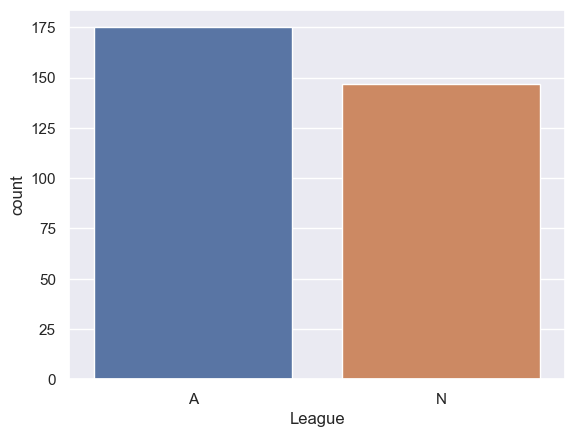

          Division  Ratio
Division                 
W              165 51.242
E              157 48.758
##########################################


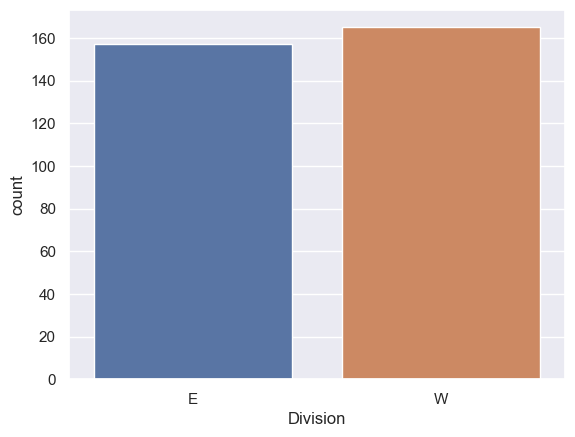

           NewLeague  Ratio
NewLeague                  
A                176 54.658
N                146 45.342
##########################################


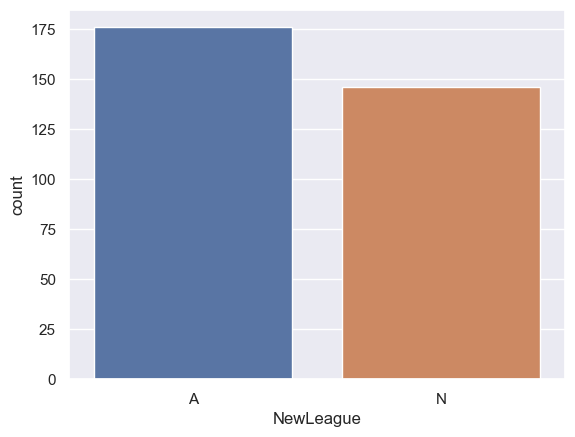

In [256]:
# Kategorik degisken analizi
def cat_summary(dataframe, col_name, plot=False):

    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")

    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show(block=True)

for col in cat_cols:
    cat_summary(df, col, plot=True)

count   322.000
mean    380.929
std     153.405
min      16.000
5%      161.000
10%     194.100
20%     221.800
30%     281.300
40%     321.800
50%     379.500
60%     430.200
70%     490.000
80%     535.600
90%     584.900
95%     609.900
99%     658.590
max     687.000
Name: AtBat, dtype: float64


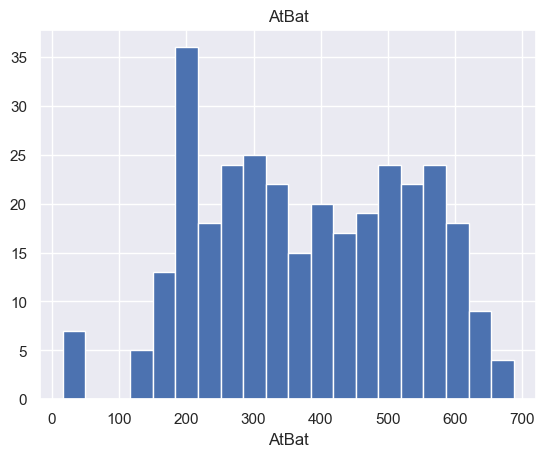

count   322.000
mean    101.025
std      46.455
min       1.000
5%       39.000
10%      45.100
20%      57.000
30%      70.000
40%      82.000
50%      96.000
60%     113.000
70%     128.700
80%     144.000
90%     163.000
95%     174.000
99%     210.790
max     238.000
Name: Hits, dtype: float64


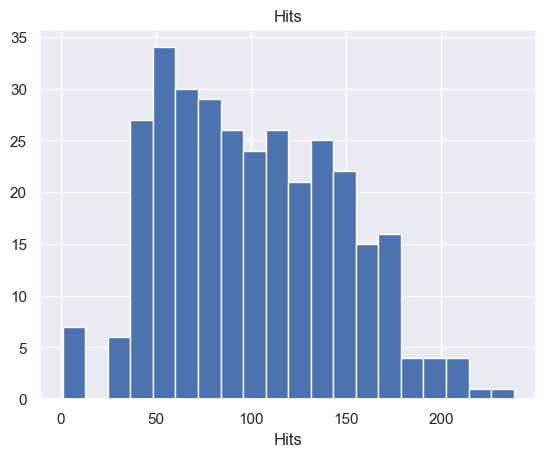

count   322.000
mean     10.770
std       8.709
min       0.000
5%        0.000
10%       1.000
20%       3.000
30%       5.000
40%       6.000
50%       8.000
60%      10.600
70%      14.000
80%      18.000
90%      24.000
95%      28.950
99%      33.000
max      40.000
Name: HmRun, dtype: float64


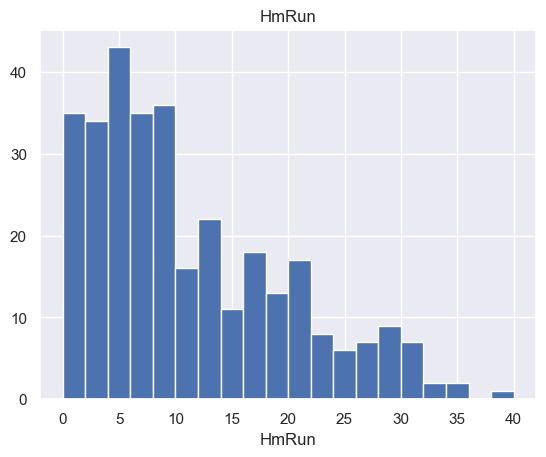

count   322.000
mean     50.910
std      26.024
min       0.000
5%       17.000
10%      20.100
20%      27.000
30%      33.000
40%      41.000
50%      48.000
60%      55.600
70%      66.000
80%      75.800
90%      89.000
95%      94.000
99%     107.790
max     130.000
Name: Runs, dtype: float64


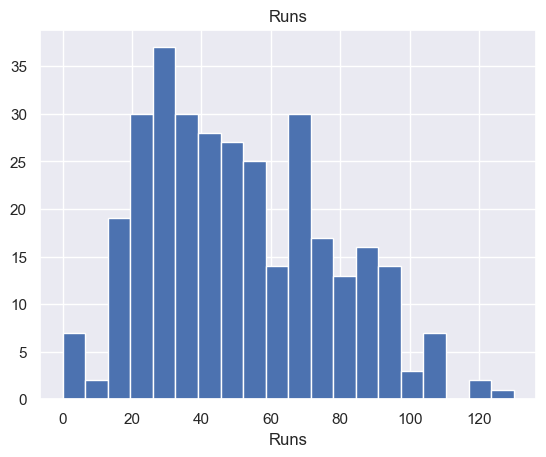

count   322.000
mean     48.028
std      26.167
min       0.000
5%       14.000
10%      19.000
20%      26.000
30%      30.000
40%      36.400
50%      44.000
60%      49.000
70%      58.000
80%      73.000
90%      86.000
95%      96.000
99%     112.370
max     121.000
Name: RBI, dtype: float64


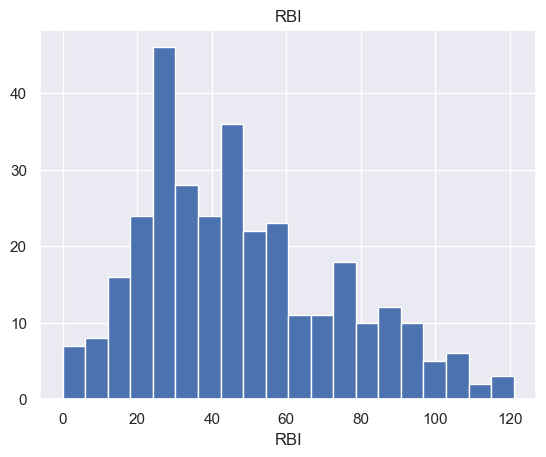

count   322.000
mean     38.742
std      21.639
min       0.000
5%       11.050
10%      15.000
20%      20.000
30%      24.000
40%      30.000
50%      35.000
60%      40.000
70%      48.700
80%      59.000
90%      69.900
95%      78.000
99%      93.580
max     105.000
Name: Walks, dtype: float64


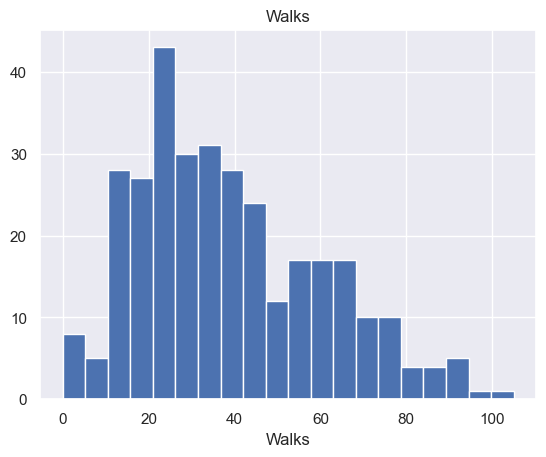

count   322.000
mean      7.444
std       4.926
min       1.000
5%        1.000
10%       2.000
20%       3.000
30%       4.000
40%       5.000
50%       6.000
60%       7.600
70%      10.000
80%      12.000
90%      15.000
95%      17.000
99%      19.790
max      24.000
Name: Years, dtype: float64


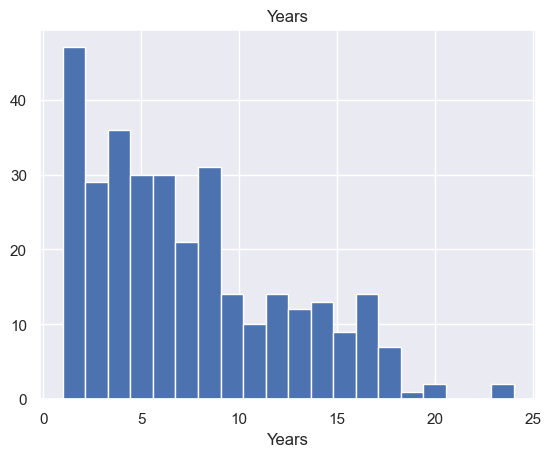

count     322.000
mean     2648.683
std      2324.206
min        19.000
5%        216.500
10%       342.200
20%       667.600
30%       963.400
40%      1402.200
50%      1928.000
60%      2654.000
70%      3365.000
80%      4483.000
90%      6123.400
95%      7125.600
99%      8749.970
max     14053.000
Name: CAtBat, dtype: float64


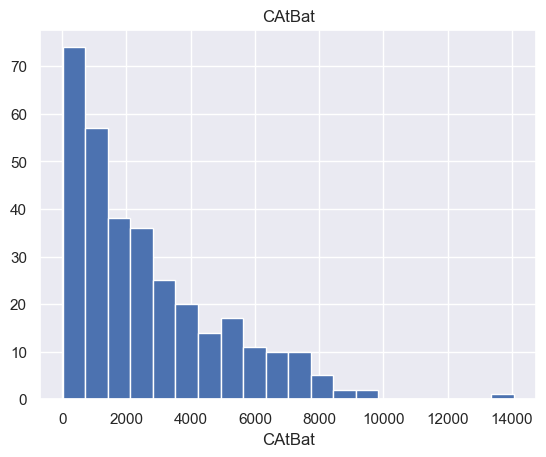

count    322.000
mean     717.571
std      654.473
min        4.000
5%        54.000
10%       86.000
20%      164.600
30%      238.000
40%      355.800
50%      508.000
60%      708.200
70%      911.100
80%     1229.200
90%     1659.600
95%     2017.150
99%     2500.340
max     4256.000
Name: CHits, dtype: float64


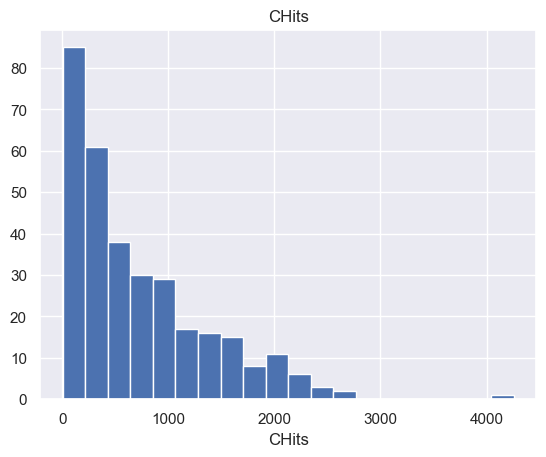

count   322.000
mean     69.491
std      86.266
min       0.000
5%        2.000
10%       4.000
20%      10.200
30%      16.300
40%      27.400
50%      37.500
60%      51.200
70%      72.400
80%     103.800
90%     194.900
95%     265.650
99%     373.120
max     548.000
Name: CHmRun, dtype: float64


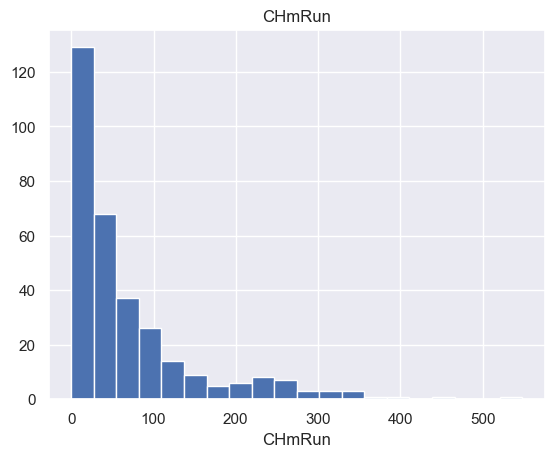

count    322.000
mean     358.795
std      334.106
min        1.000
5%        27.000
10%       38.100
20%       80.400
30%      117.300
40%      181.000
50%      247.000
60%      333.000
70%      443.400
80%      627.200
90%      895.700
95%     1032.300
99%     1174.370
max     2165.000
Name: CRuns, dtype: float64


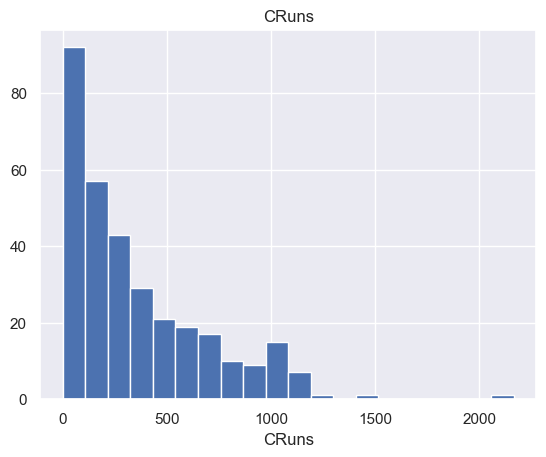

count    322.000
mean     330.118
std      333.220
min        0.000
5%        22.050
10%       34.100
20%       70.200
30%      106.300
40%      149.000
50%      220.500
60%      303.600
70%      379.100
80%      496.200
90%      861.600
95%     1071.750
99%     1310.850
max     1659.000
Name: CRBI, dtype: float64


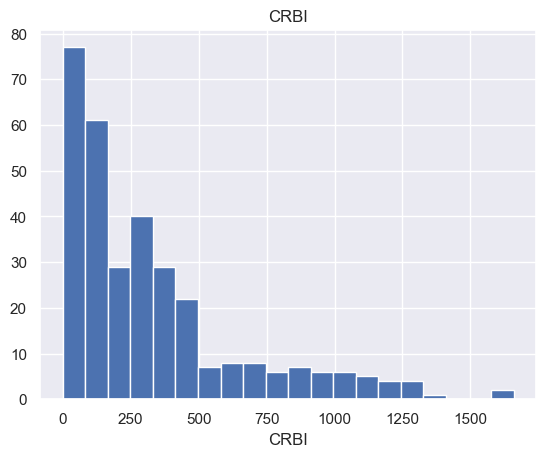

count    322.000
mean     260.239
std      267.058
min        0.000
5%        15.050
10%       30.100
20%       55.000
30%       82.000
40%      117.400
50%      170.500
60%      226.600
70%      300.700
80%      421.000
90%      643.900
95%      817.600
99%     1139.140
max     1566.000
Name: CWalks, dtype: float64


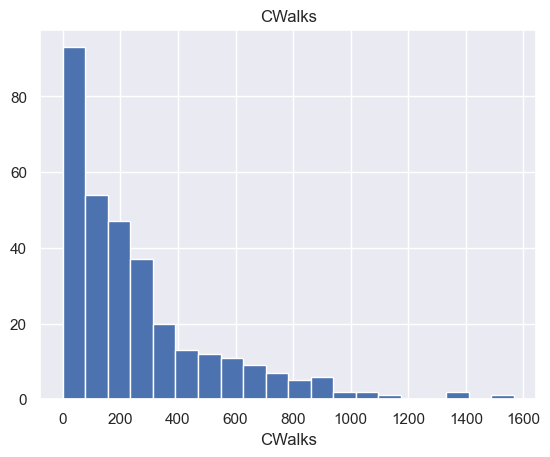

count    322.000
mean     288.938
std      280.705
min        0.000
5%        33.200
10%       62.200
20%       99.600
30%      132.000
40%      167.000
50%      212.000
60%      257.400
70%      303.000
80%      365.800
90%      685.600
95%      910.650
99%     1301.190
max     1378.000
Name: PutOuts, dtype: float64


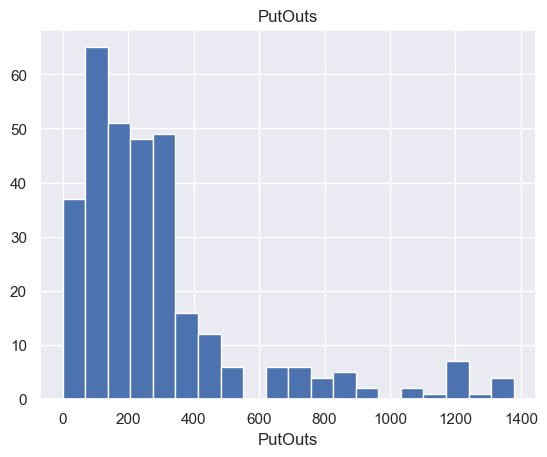

count   322.000
mean    106.913
std     136.855
min       0.000
5%        0.000
10%       2.000
20%       5.200
30%       9.000
40%      15.400
50%      39.500
60%      76.800
70%     134.800
80%     210.800
90%     353.300
95%     431.450
99%     478.160
max     492.000
Name: Assists, dtype: float64


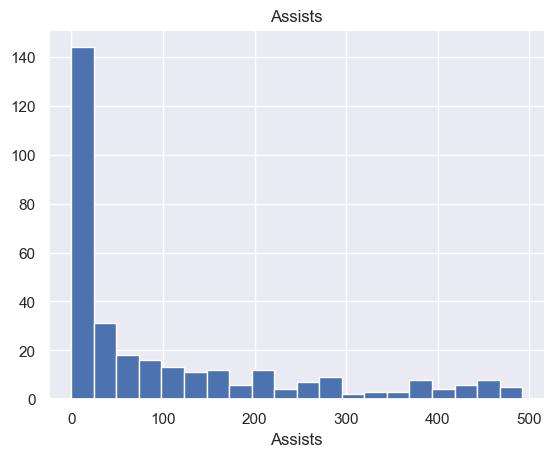

count   322.000
mean      8.040
std       6.368
min       0.000
5%        0.000
10%       1.000
20%       3.000
30%       4.000
40%       5.000
50%       6.000
60%       8.000
70%      10.000
80%      13.000
90%      17.000
95%      20.000
99%      25.790
max      32.000
Name: Errors, dtype: float64


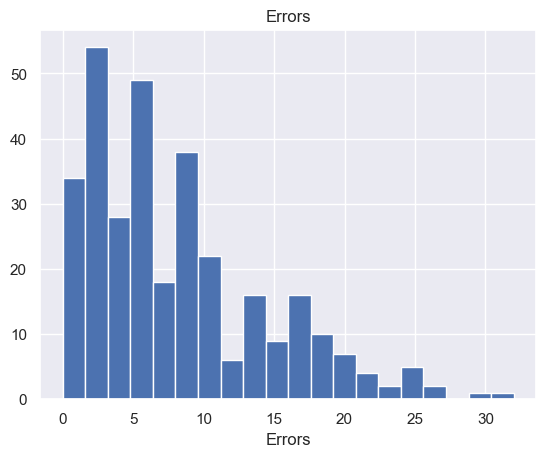

count    263.000
mean     535.926
std      451.119
min       67.500
5%        86.600
10%      100.000
20%      155.000
30%      221.000
40%      300.000
50%      425.000
60%      538.000
70%      700.000
80%      809.000
90%     1048.667
95%     1346.000
99%     2032.887
max     2460.000
Name: Salary, dtype: float64


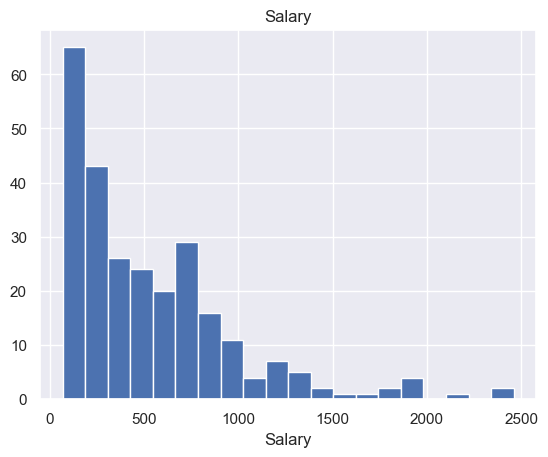

In [257]:
# Numerik degisken analizi
def num_summary(dataframe, numerical_col, plot=False):

    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]

    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)

for col in num_cols:
    num_summary(df, col, plot=True)

In [258]:
# Hedef degisken analizi
def target_summary_with_cat(dataframe, target, categorical_col):

    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")

for col in cat_cols:
    target_summary_with_cat(df, "Salary", col)

        TARGET_MEAN
League             
A           542.000
N           529.118


          TARGET_MEAN
Division             
E             624.271
W             450.877


           TARGET_MEAN
NewLeague             
A              537.113
N              534.554




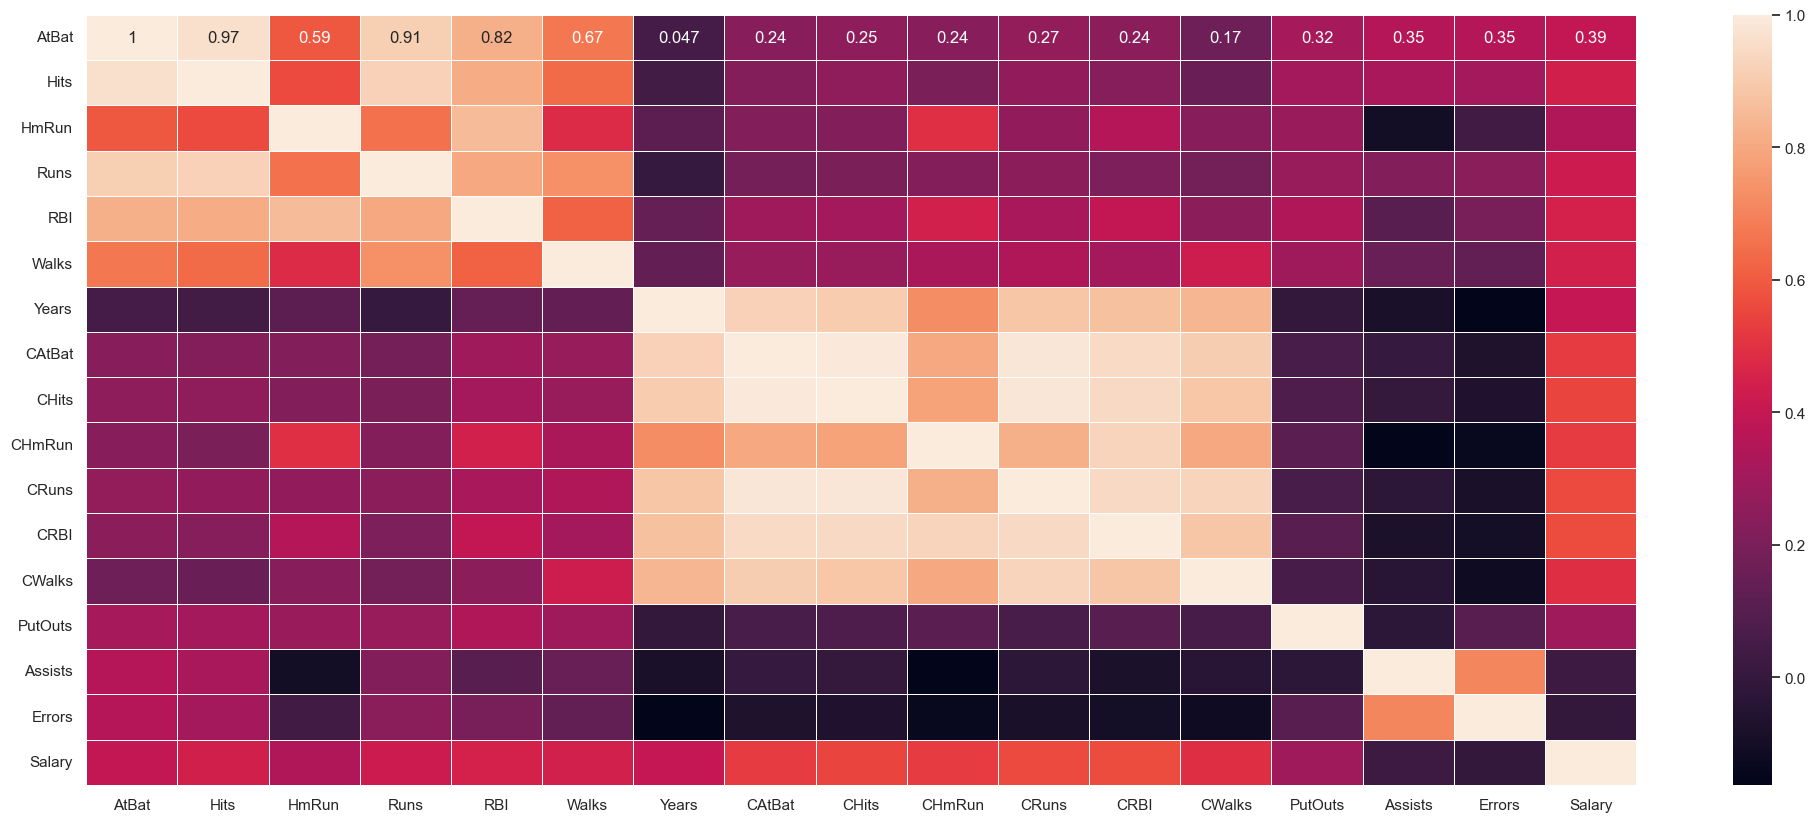

In [259]:
# Korelasyon analizi 
df[num_cols].corr(method="spearman")

fig, ax = plt.subplots(figsize=(25,10))
sns.heatmap(df[num_cols].corr(), annot=True, linewidths=.5, ax=ax)
plt.show()

In [260]:
def find_correlation(dataframe, numeric_cols, corr_limit=0.60):
    high_correlations = []
    low_correlations = []
    for col in numeric_cols:
        if col == "Salary":
            pass
        else:
            correlation = dataframe[[col, "Salary"]].corr().loc[col, "Salary"]
            print(col, correlation)
            if abs(correlation) > corr_limit:
                high_correlations.append(col + ": " + str(correlation))
            else:
                low_correlations.append(col + ": " + str(correlation))
    return low_correlations, high_correlations


low_corrs, high_corrs = find_correlation(df, num_cols)

AtBat 0.39477094475973734
Hits 0.4386747378694112
HmRun 0.34302807815466363
Runs 0.4198585593019815
RBI 0.4494570879400337
Walks 0.44386726016297945
Years 0.40065699438268604
CAtBat 0.5261353096237892
CHits 0.5489095590351705
CHmRun 0.5249305595435935
CRuns 0.5626777110048051
CRBI 0.5669656856176524
CWalks 0.48982203628068005
PutOuts 0.30048035550600516
Assists 0.025436135647346703
Errors -0.005400701500953135


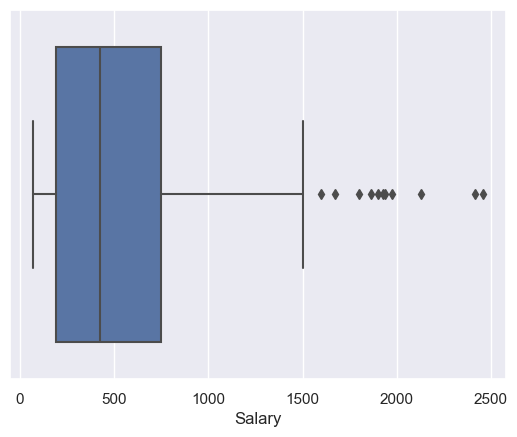

In [261]:
# Outlier bulmak
sns.boxplot(x=df["Salary"], data=df)
plt.show(block=True)

In [262]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [263]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [264]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [265]:
for col in num_cols:
    print(col, check_outlier(df, col))

AtBat False
Hits False
HmRun True
Runs True
RBI True
Walks True
Years True
CAtBat True
CHits True
CHmRun True
CRuns True
CRBI True
CWalks True
PutOuts True
Assists True
Errors True
Salary True


In [266]:
for col in num_cols:
    if check_outlier(df, col):
        replace_with_thresholds(df, col)

In [267]:
# Eksik degerler
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")
    if na_name:
        return na_columns

In [268]:
missing_values_table(df)

        n_miss  ratio
Salary      59 18.320


In [269]:
df1 = df.copy()
df1.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30.000,29.000,14.000,1.000,293.000,66.000,1,30.000,29.000,14.000,A,E,446.000,33.000,20,NaN,A
1,315,81,7,24.000,38.000,39.000,14.000,3449.000,835.000,69,321.000,414.000,375.000,N,W,632.000,43.000,10,475.000,N
2,479,130,18,66.000,72.000,76.000,3.000,1624.000,457.000,63,224.000,266.000,263.000,A,W,648.625,82.000,14,480.000,A
3,496,141,20,65.000,78.000,37.000,11.000,5628.000,1575.000,204,828.000,838.000,354.000,N,E,200.000,11.000,3,500.000,N
4,321,87,10,39.000,42.000,30.000,2.000,396.000,101.000,12,48.000,46.000,33.000,N,E,648.625,40.000,4,91.500,N


In [270]:
cat_cols, num_cols, cat_but_car = grab_col_names(df1)

Observations: 322
Variables: 20
cat_cols: 3
num_cols: 17
cat_but_car: 0
num_but_cat: 0


In [271]:
df1.isnull().sum()

AtBat         0
Hits          0
HmRun         0
Runs          0
RBI           0
Walks         0
Years         0
CAtBat        0
CHits         0
CHmRun        0
CRuns         0
CRBI          0
CWalks        0
League        0
Division      0
PutOuts       0
Assists       0
Errors        0
Salary       59
NewLeague     0
dtype: int64

In [272]:
# Eksik degerleri doldurma
def eksik_veri_doldur(dataframe):

        df1 = dataframe.copy()
        cat_cols, num_cols, cat_but_car = grab_col_names(df1)
    
        dff = pd.get_dummies(df1[cat_cols + num_cols], drop_first=True)
        scaler = RobustScaler()
        dff = pd.DataFrame(scaler.fit_transform(dff), columns=dff.columns)
        imputer = KNNImputer(n_neighbors=5)
        dff = pd.DataFrame(imputer.fit_transform(dff), columns=dff.columns)
        dff = pd.DataFrame(scaler.inverse_transform(dff), columns=dff.columns)
        df1 = dff
        return df1

In [273]:
df1 = eksik_veri_doldur(df)

Observations: 322
Variables: 20
cat_cols: 3
num_cols: 17
cat_but_car: 0
num_but_cat: 0


In [274]:
df1.isnull().sum()

AtBat          0
Hits           0
HmRun          0
Runs           0
RBI            0
Walks          0
Years          0
CAtBat         0
CHits          0
CHmRun         0
CRuns          0
CRBI           0
CWalks         0
PutOuts        0
Assists        0
Errors         0
Salary         0
League_N       0
Division_W     0
NewLeague_N    0
dtype: int64

In [275]:
new_num_cols=[col for col in num_cols if col!="Salary"]
df1[new_num_cols]=df1[new_num_cols]+0.0000000001

In [276]:
df1["Hits_Success"] = (df1["Hits"] / df1["AtBat"]) * 100
df1['NEW_RBI'] = df1['RBI'] / df1['CRBI']
df1['NEW_Walks'] = df1['Walks'] / df1['CWalks']
df1['NEW_PutOuts'] = df1['PutOuts'] * df1['Years']
df1['NEW_Hits'] = df1['Hits'] / df1['CHits'] + df1['Hits']
df1["NEW_CRBI*CATBAT"] = df1['CRBI'] * df1['CAtBat']
df1["NEW_Chits"] = df1["CHits"] / df1["Years"]
df1["NEW_CHmRun"] = df1["CHmRun"] * df1["Years"]
df1["NEW_CRuns"] = df1["CRuns"] / df1["Years"]
df1["NEW_Chits"] = df1["CHits"] * df1["Years"]
df1["NEW_RW"] = df1["RBI"] * df1["Walks"]
df1["NEW_RBWALK"] = df1["RBI"] / df1["Walks"]
df1["NEW_CH_CB"] = df1["CHits"] / df1["CAtBat"]
df1["NEW_CHm_CAT"] = df1["CHmRun"] / df1["CAtBat"]
df1['NEW_Diff_Atbat'] = df1['AtBat'] - (df1['CAtBat'] / df1['Years'])
df1['NEW_Diff_Hits'] = df1['Hits'] - (df1['CHits'] / df1['Years'])
df1['NEW_Diff_HmRun'] = df1['HmRun'] - (df1['CHmRun'] / df1['Years'])
df1['NEW_Diff_Runs'] = df1['Runs'] - (df1['CRuns'] / df1['Years'])
df1['NEW_Diff_RBI'] = df1['RBI'] - (df1['CRBI'] / df1['Years'])
df1['NEW_Diff_Walks'] = df1['Walks'] - (df1['CWalks'] / df1['Years'])

In [277]:
def feature_ext(df1):
    cat_cols, num_cols, cat_but_car = grab_col_names(df1)
    new_num_cols = [col for col in num_cols if col != "Salary"]
    df1[new_num_cols] = df1[new_num_cols] + 0.0000000001

    df1['NEW_Hits'] = df1['Hits'] / df1['CHits'] + df1['Hits']
    df1['NEW_RBI'] = df1['RBI'] / df1['CRBI']
    df1['NEW_Walks'] = df1['Walks'] / df1['CWalks']
    df1['NEW_PutOuts'] = df1['PutOuts'] * df1['Years']
    df1["Hits_Success"] = (df1["Hits"] / df1["AtBat"]) * 100
    df1["NEW_CRBI*CATBAT"] = df1['CRBI'] * df1['CAtBat']
    df1["NEW_RBI"] = df1["RBI"] / df1["CRBI"]
    df1["NEW_Chits"] = df1["CHits"] / df1["Years"]
    df1["NEW_CHmRun"] = df1["CHmRun"] * df1["Years"]
    df1["NEW_CRuns"] = df1["CRuns"] / df1["Years"]
    df1["NEW_Chits"] = df1["CHits"] * df1["Years"]
    df1["NEW_RW"] = df1["RBI"] * df1["Walks"]
    df1["NEW_RBWALK"] = df1["RBI"] / df1["Walks"]
    df1["NEW_CH_CB"] = df1["CHits"] / df1["CAtBat"]
    df1["NEW_CHm_CAT"] = df1["CHmRun"] / df1["CAtBat"]
    df1['NEW_Diff_Atbat'] = df1['AtBat'] - (df1['CAtBat'] / df1['Years'])
    df1['NEW_Diff_Hits'] = df1['Hits'] - (df1['CHits'] / df1['Years'])
    df1['NEW_Diff_HmRun'] = df1['HmRun'] - (df1['CHmRun'] / df1['Years'])
    df1['NEW_Diff_Runs'] = df1['Runs'] - (df1['CRuns'] / df1['Years'])
    df1['NEW_Diff_RBI'] = df1['RBI'] - (df1['CRBI'] / df1['Years'])
    df1['NEW_Diff_Walks'] = df1['Walks'] - (df1['CWalks'] / df1['Years'])
    return df1

In [278]:
# One-Hot Encoding
cat_cols, num_cols, cat_but_car = grab_col_names(df1)

def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    for col in dataframe.columns:
        if dataframe[col].dtype == 'bool':
            dataframe[col] = dataframe[col].astype(int)
    return dataframe

df1 = one_hot_encoder(df1, cat_cols, drop_first=True)

Observations: 322
Variables: 39
cat_cols: 3
num_cols: 36
cat_but_car: 0
num_but_cat: 3


In [279]:
# Feature Scaling
cat_cols, num_cols, cat_but_car = grab_col_names(df1)

num_cols = [col for col in num_cols if col not in ["Salary"]]
scaler = StandardScaler()
df1[num_cols] = scaler.fit_transform(df1[num_cols])
df1.head()

Observations: 322
Variables: 39
cat_cols: 3
num_cols: 36
cat_but_car: 0
num_but_cat: 3


,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary,Hits_Success,NEW_RBI,NEW_Walks,NEW_PutOuts,NEW_Hits,NEW_CRBI*CATBAT,NEW_Chits,NEW_CHmRun,NEW_CRuns,NEW_RW,NEW_RBWALK,NEW_CH_CB,NEW_CHm_CAT,NEW_Diff_Atbat,NEW_Diff_Hits,NEW_Diff_HmRun,NEW_Diff_Runs,NEW_Diff_RBI,NEW_Diff_Walks,League_N_1.0,Division_W_1.0,NewLeague_N_1.0
0,-0.574,-0.755,-1.130,-0.805,-0.728,-1.147,-1.318,-1.043,-1.035,-0.956,-1.023,-0.995,-1.036,1.049,-0.549,1.977,82.900,-0.956,2.214,2.285,-0.658,-0.741,-0.672,-0.741,-0.682,-0.631,-0.901,0.829,-1.415,-1.363,-0.513,-0.456,-0.611,-0.422,-0.608,-0.624,0,0,0
1,-0.430,-0.432,-0.434,-1.036,-0.384,0.013,1.346,0.369,0.204,0.119,-0.105,0.363,0.582,2.060,-0.471,0.337,475.000,-0.076,-0.798,-0.767,3.224,-0.437,0.002,0.343,0.275,-0.967,-0.363,-0.558,-0.752,-0.230,0.091,0.195,-0.198,-0.363,-0.109,0.252,1,1,1
2,0.640,0.625,0.840,0.582,0.918,1.729,-0.908,-0.448,-0.405,0.024,-0.411,-0.159,0.080,2.151,-0.170,0.993,480.000,0.317,-0.204,-0.137,0.035,0.624,-0.471,-0.619,-0.496,1.493,1.634,-0.592,0.794,1.052,-1.061,-1.136,-1.209,-0.901,-1.594,-1.461,0,1,0
3,0.751,0.862,1.072,0.543,1.148,-0.080,0.731,1.344,1.396,2.254,1.495,1.859,0.488,-0.289,-0.719,-0.812,500.000,0.672,-0.793,-0.765,0.152,0.858,1.563,0.869,1.542,1.522,0.340,0.875,0.733,0.878,-0.651,-0.522,-0.321,-0.989,-0.500,-0.279,1,0,1
4,-0.391,-0.302,-0.087,-0.458,-0.231,-0.405,-1.113,-0.997,-0.979,-0.782,-0.966,-0.935,-0.951,2.151,-0.494,-0.648,91.500,0.307,1.926,1.975,-0.265,-0.291,-0.668,-0.728,-0.659,-0.916,-0.474,-0.020,-0.243,0.473,0.569,0.656,0.186,0.407,0.517,0.344,1,0,1


In [280]:
def feature_scaling(dataframe, num_cols):
    # Özellik ölçeklendirme işlemleri
    scaler = StandardScaler()
    cat_cols, num_cols, cat_but_car = grab_col_names(dataframe)
    num_cols = [col for col in num_cols if col not in ["Salary"]]
    dataframe[num_cols] = scaler.fit_transform(dataframe[num_cols])
    return dataframe

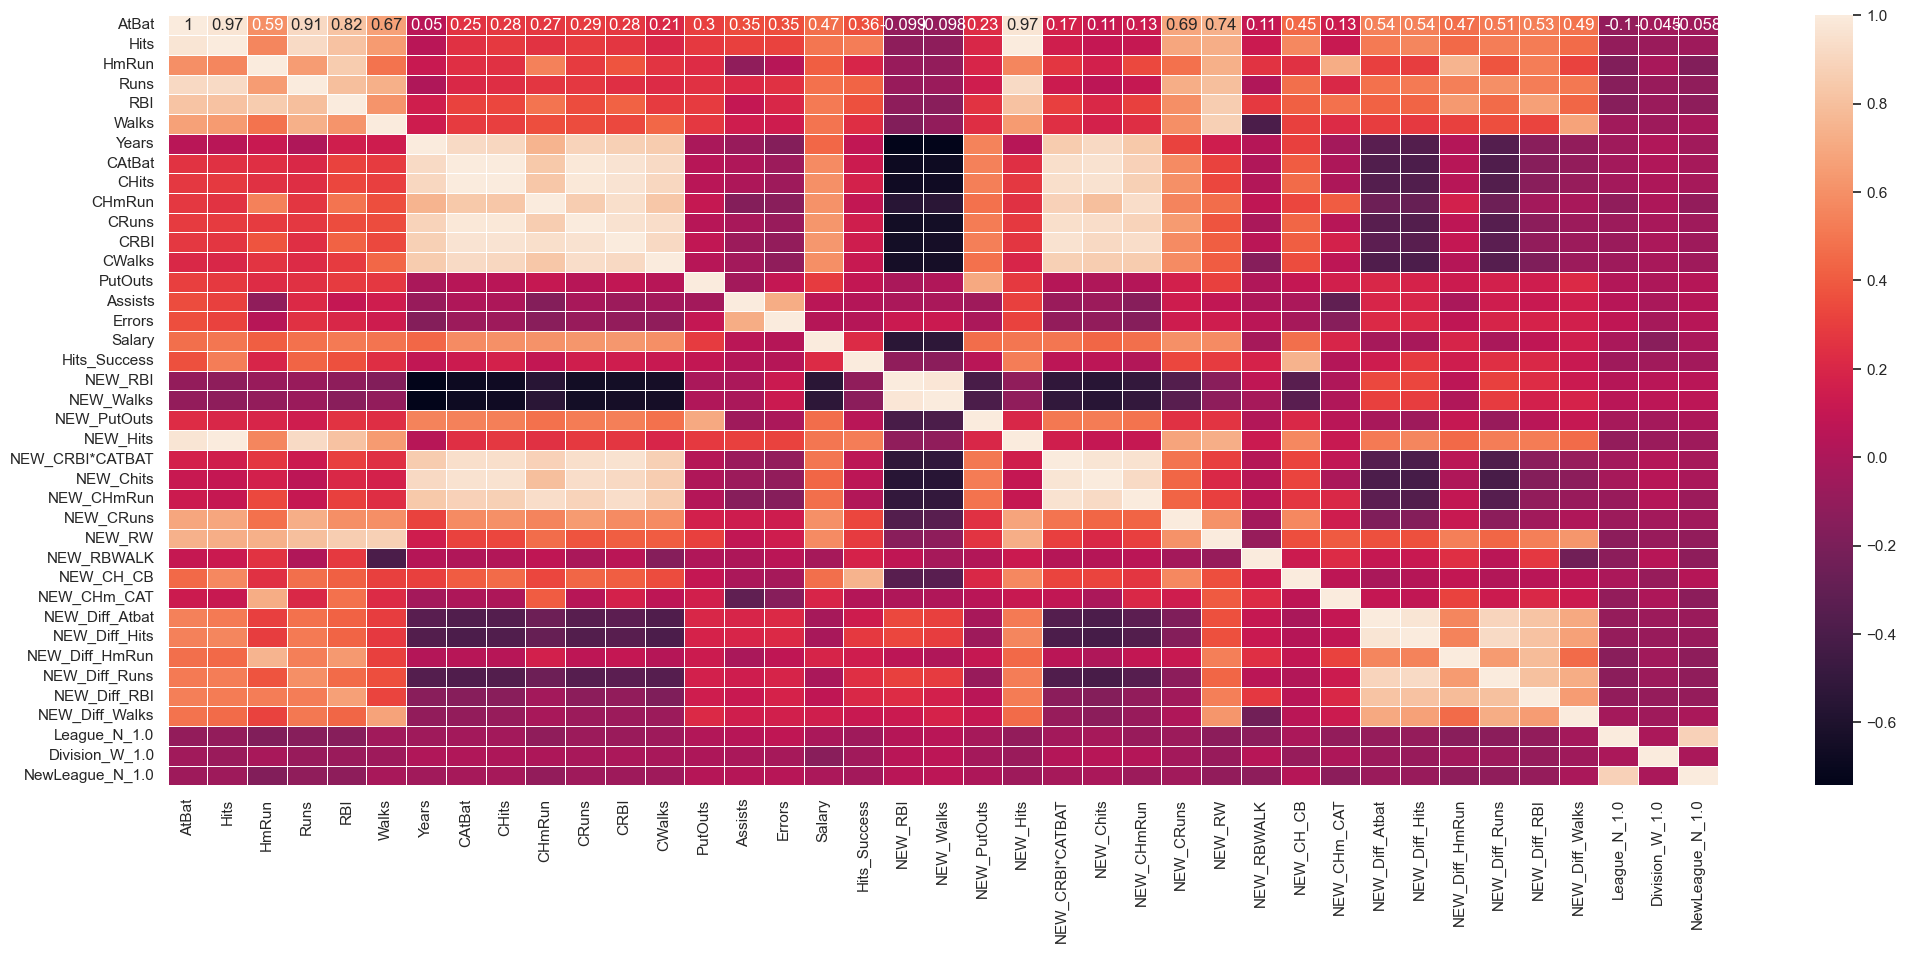

In [281]:
fig, ax = plt.subplots(figsize=(25,10))
sns.heatmap(df1.corr(), annot=True, linewidths=.5, ax=ax)
plt.show()

In [282]:
# MODEL
df1.isnull().sum().sum()

0

In [283]:
y = df1["Salary"]
X = df1.drop(["Salary"], axis=1)

In [284]:
X.shape

(322, 38)

In [285]:
y.shape

(322,)

In [286]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.20,
                                                    random_state=46)

In [287]:
linreg = LinearRegression()
model = linreg.fit(X_train,y_train)
y_pred = model.predict(X_train)

In [294]:
y_pred

array([ 215.82169249,  305.4313456 ,  476.02912535,   40.86626475,
        110.75974973,  390.48901004,  213.12970369,  120.1359543 ,
        452.21648022,  171.31739241,  437.10554828,  938.72864791,
       1088.12414063,  141.07969342,  116.26674642,  290.47168548,
        239.45733944,  389.75029968,  480.81801698,   53.76671935,
       1216.74083163,  433.69321774,  270.58908872,  175.80635983,
        387.82035289,  177.69199716,  767.81081747,  205.13103015,
       1176.15573596,  285.58908027, 1160.22449279,  218.35379045,
        528.35265208,  295.43686154,  577.82536132,  121.75514975,
        380.11235108,  494.64812988,  593.67463987,  520.0107063 ,
        680.0702707 ,  302.61649323,  336.14522461,  713.71270846,
        198.88017404,  514.26375863,  374.8404777 ,  185.26355801,
       1178.49528097,  601.7339579 ,  288.25664806,  412.01383385,
        278.80563373,  707.2119705 ,  791.25498498,  559.36634189,
        877.91112015,  339.46417378,  271.14865569,  734.27508

In [288]:
lin_train_rmse =np.sqrt(mean_squared_error(y_train,y_pred))
print("LINEAR REGRESSION TRAIN RMSE:", "{:,.2f}".format(np.sqrt(mean_squared_error(y_train,y_pred))))

LINEAR REGRESSION TRAIN RMSE: 190.90


In [289]:
lin_train_r2 = linreg.score(X_train,y_train)
print("LINEAR REGRESSION TRAIN R-SQUARED:", "{:,.3f}".format(linreg.score(X_train,y_train)))

LINEAR REGRESSION TRAIN R-SQUARED: 0.757


In [290]:
y_pred = model.predict(X_test)
lin_test_rmse =np.sqrt(mean_squared_error(y_test,y_pred))
print("LINEAR REGRESSION TEST RMSE:", "{:,.2f}".format(np.sqrt(mean_squared_error(y_test,y_pred))))

LINEAR REGRESSION TEST RMSE: 194.99


In [291]:
lin_test_r2 = linreg.score(X_test,y_test)
print("LINEAR REGRESSION TEST R-SQUARED:", "{:,.3f}".format(linreg.score(X_test,y_test)))

LINEAR REGRESSION TEST R-SQUARED: 0.721


In [292]:
print("LINEAR REGRESSION CROSS_VAL_SCORE:", "{:,.3f}".format(np.mean(np.sqrt(-cross_val_score(model,
                                 X,
                                 y,
                                 cv=10,
                                 scoring="neg_mean_squared_error")))))

LINEAR REGRESSION CROSS_VAL_SCORE: 224.551


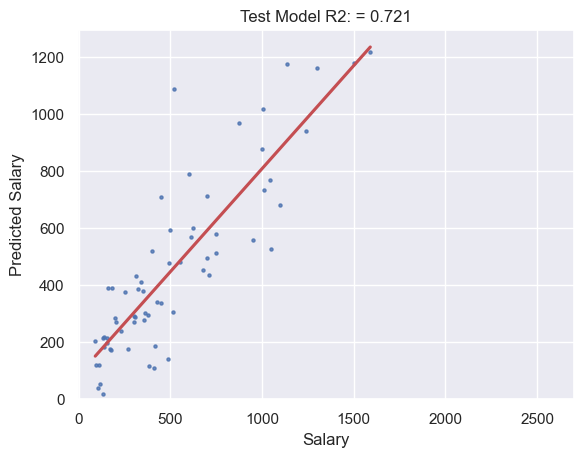

In [293]:
g = sns.regplot(x=y_test, y=y_pred, scatter_kws={'color': 'b', 's': 5},
                ci=False, color="r")
g.set_title(f"Test Model R2: = {linreg.score(X_test, y_test):.3f}")
g.set_ylabel("Predicted Salary")
g.set_xlabel("Salary")
plt.xlim(-5, 2700)
plt.ylim(bottom=0)
plt.show(block=True)